# Crop Production Prediction Based on Factors, Using Regression Analysis
For this file we have amulgamated 10 datasets for predicting the production of wheat, rice, soybean and maize. We have incorporate pesticide, Co2, Change in temperature, fertilizer (N, P and K which are required for the growth of the crop) and arable land datasets. We have 2 more dataset one for checking the country codes and other for imputing the missing change in temperature values.

In [ ]:
# !pip install pandas-profiling

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# mount google drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
profdrive="/content/drive/MyDrive/ML-Summer-2023/The Martians/Data"
file_name1="Disaster_data/temperature_data.csv"
file_name2="Disaster_data/Climate-related_Disasters_Frequency.csv"
file_name3="FT2021_fossil_CO2_booklet_2022.xlsx"
file_name4="country_codes.csv"
file_name5="Disaster_data/pesticides.csv"
file_name6="Disaster_data/fertilizer.csv"
file_name7="Disaster_data/arable_land.csv"
file_name8="wheat-production.csv"
file_name9="rice-production.csv"
file_name10="soybean-production.csv"
file_name11="maize-production.csv"
file_name12="missing_country_temp.csv"

import os
os.chdir(profdrive)

In [ ]:
#CO2 data
data_co2= pd.read_excel(file_name3,sheet_name="fossil_CO2_totals_by_country")
# temperature data
data_temp= pd.read_csv(file_name1)##, encoding='cp1252'
# Disaster data
data_disaster = pd.read_csv(file_name2)
#Country code data
data_country_code=pd.read_csv(file_name4)
#Peticide data
data_pesticide=pd.read_csv(file_name5)
#Fertilizer data (Nitrogen, Potassium and potash)
data_fertilizer=pd.read_csv(file_name6)
#arable land data
data_arable=pd.read_csv(file_name7)
#Wheat data
data_wheat=pd.read_csv(file_name8)
#Rice data
data_rice=pd.read_csv(file_name9)
#Soybean data
data_soybean=pd.read_csv(file_name10)
#Maize data
data_maize=pd.read_csv(file_name11)
#Missing temperature data
missing_temp=pd.read_csv(file_name12)

In [ ]:
def removeDataWithoutCode(df,code):

  df_ = df[df[code].notna()]
  df_=df_[~(df_[code]=='')]

  df_ = df_[df_[code].isin(data_country_code['Code'])]
  return df_

In [ ]:
def trimDataFrame(df,start,end):
  df_trimmed= (
      df
      .query(f'Year >= {start} and Year <={end}')
  )

  return df_trimmed

# Data Cleaning and Data Preprocessing

In [ ]:
data_co2_country=removeDataWithoutCode(data_co2,"EDGAR Country Code")

In [ ]:
data_co2_country= data_co2_country.rename(columns={'EDGAR Country Code':'Code'})

data_co2_country.drop('Substance', inplace=True, axis =1)
data_co2_country.drop('Country', inplace=True, axis =1)

In [ ]:
df_co2_ = pd.melt(data_co2_country, id_vars=['Code'] , var_name='Year', value_name ='CO2')

In [ ]:
df_co2_ ['Year']=df_co2_ ['Year'].astype('int')
data_country_code.head()

,Code,Country
0,AFG,Afghanistan
1,ALA,Aland Islands
2,ALB,Albania
3,DZA,Algeria
4,ASM,American Samoa


In [ ]:
df_temp_country= removeDataWithoutCode(data_temp,"Area Code (ISO3)")
df_temp_country=df_temp_country.rename(columns={'Area Code (ISO3)':'Code'})
df_temp_country=df_temp_country.rename(columns={'Value':'temp_change'})
df_temp_country.drop(['Domain Code', 'Domain','Area',	'Element Code',	'Element', 'Months Code', 'Months',	'Year Code', 'Unit', 'Flag',	'Flag Description'], inplace=True, axis =1)

In [ ]:
disaster=list(data_disaster["Indicator"].unique())
result =list( map(lambda x: x.split(":")[-1].strip(), disaster))
data_disaster['Indicator'] = data_disaster['Indicator'].replace(disaster,result)
data_disaster=data_disaster.rename(columns={'ISO3':"Code",'F1980':"1980", 'F1981':"1981",
       'F1982':"1982", 'F1983':"1983", 'F1984':"1984", 'F1985':"1985", 'F1986':"1986", 'F1987':"1987", 'F1988':"1988", 'F1989':"1989",
       'F1990':"1990", 'F1991':"1991", 'F1992':"1992", 'F1993':"1993", 'F1994':"1994", 'F1995':"1995", 'F1996':"1996", 'F1997':"1997",
       'F1998':"1998", 'F1999':"1999", 'F2000':"2000", 'F2001':"2001", 'F2002':"2002", 'F2003':"2003", 'F2004':"2004", 'F2005':"2005",
       'F2006': "2006", 'F2007':"2007", 'F2008':"2008", 'F2009':"2009", 'F2010':"2010", 'F2011':"2011", 'F2012':"2012", 'F2013':"2013",
       'F2014':"2014", 'F2015':"2015", 'F2016':"2016", 'F2017':"2017", 'F2018':"2018", 'F2019':"2019", 'F2020':"2020", 'F2021':"2021",
       'F2022':"2022"})
data_disaster.fillna(0,inplace=True)
data_disaster=data_disaster[['Country','Code', 'Indicator', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022']]

data_disaster_clean=data_disaster[data_disaster["Indicator"]!="TOTAL"]

data_disaster_country=removeDataWithoutCode(data_disaster_clean,"Code")

data_disaster_country.drop(["Country"], axis=1, inplace=True)

data_disaster_country.head()

,Code,Indicator,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Drought,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,AFG,Extreme temperature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Flood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,1.0,4.0,1.0,3.0,6.0,5.0,2.0,5.0
3,AFG,Landslide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,4.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0
4,AFG,Storm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_new_dis_ = pd.melt(data_disaster_country, id_vars=['Code','Indicator'] , var_name='Year', value_name ='Disaster')
df_pivoted_disaster = df_new_dis_.pivot(index=['Code', 'Year'], columns='Indicator', values='Disaster')
df_flattened_disaster = df_pivoted_disaster.reset_index()
df_flattened_disaster = df_flattened_disaster.rename_axis(None, axis=1)

In [ ]:
df_flattened_disaster.fillna(0,inplace=True)
for y in ['Year','Drought', 'Extreme temperature', 'Flood', 'Landslide',
       'Storm', 'Wildfire']:
       df_flattened_disaster[y]=df_flattened_disaster[y].astype(int)

df_flat_disaster=trimDataFrame(df_flattened_disaster,1970,2021)
df_flat_disaster.isna().sum()

Code                   0
Year                   0
Drought                0
Extreme temperature    0
Flood                  0
Landslide              0
Storm                  0
Wildfire               0
dtype: int64

In [ ]:
data_pesticide.isna().sum()

Domain Code         0
Domain              0
Area Code (ISO3)    0
Area                0
Element Code        0
Element             0
Item Code           0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [ ]:
data_pesticide.drop(['Domain Code',	'Domain','Area','Element Code','Element',	'Item Code', 'Item',	'Year Code', 'Unit', 'Flag', 'Flag Description'], axis=1, inplace=True)

In [ ]:
data_pesticide=data_pesticide.rename(columns={'Area Code (ISO3)':"Code","Value":"pesticide_use"})
data_pesticide

,Code,Year,pesticide_use
0,ALB,1990,0.17
1,ALB,1991,0.17
2,ALB,1992,0.17
3,ALB,1993,0.17
4,ALB,1994,0.29
...,...,...,...
5869,ZWE,2017,0.53
5870,ZWE,2018,0.53
5871,ZWE,2019,0.53
5872,ZWE,2020,0.53


In [ ]:
data_fertilizer['Item'].unique()

array(['Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)'], dtype=object)

In [ ]:
data_fertilizer.isna().sum()

Domain Code             0
Domain                  0
Area Code (ISO3)        0
Area                    0
Element Code            0
Element                 0
Item Code               0
Item                    0
Year Code               0
Year                    0
Unit                11595
Value               11595
Flag                11595
Flag Description    11595
Note                37908
dtype: int64

In [ ]:
data_N=data_fertilizer[data_fertilizer['Item']=='Nutrient nitrogen N (total)']
data_P=data_fertilizer[data_fertilizer['Item']=='Nutrient phosphate P2O5 (total)']
data_K=data_fertilizer[data_fertilizer['Item']=='Nutrient potash K2O (total)']

In [ ]:
data_N.drop(['Domain Code',	'Domain','Area','Element Code','Element',	'Item Code', 'Item',	'Year Code', 'Unit', 'Flag', 'Flag Description','Note'], axis=1, inplace=True)
data_P.drop(['Domain Code',	'Domain','Area','Element Code','Element',	'Item Code', 'Item',	'Year Code', 'Unit', 'Flag', 'Flag Description','Note'], axis=1, inplace=True)
data_K.drop(['Domain Code',	'Domain','Area','Element Code','Element',	'Item Code', 'Item',	'Year Code', 'Unit', 'Flag', 'Flag Description','Note'], axis=1, inplace=True)

In [ ]:
data_N=data_N.rename(columns={'Area Code (ISO3)':"Code","Value":"N_content"})
data_P=data_P.rename(columns={'Area Code (ISO3)':"Code","Value":"P_content"})
data_K=data_K.rename(columns={'Area Code (ISO3)':"Code","Value":"K_content"})

In [ ]:
data_N.fillna(0,inplace=True)
data_P.fillna(0,inplace=True)
data_K.fillna(0,inplace=True)

In [ ]:
print(data_N.isna().sum())
print("-"*20)
print(data_P.isna().sum())
print("-"*20)
print(data_K.isna().sum())

Code         0
Year         0
N_content    0
dtype: int64
--------------------
Code         0
Year         0
P_content    0
dtype: int64
--------------------
Code         0
Year         0
K_content    0
dtype: int64


In [ ]:
data_arable.head()

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,RL,Land Use,AFG,Afghanistan,5110,Area,6621,Arable land,1961,1961,1000 ha,7650.0,I,Imputed value
1,RL,Land Use,AFG,Afghanistan,5110,Area,6621,Arable land,1962,1962,1000 ha,7700.0,I,Imputed value
2,RL,Land Use,AFG,Afghanistan,5110,Area,6621,Arable land,1963,1963,1000 ha,7750.0,I,Imputed value
3,RL,Land Use,AFG,Afghanistan,5110,Area,6621,Arable land,1964,1964,1000 ha,7800.0,A,Official figure
4,RL,Land Use,AFG,Afghanistan,5110,Area,6621,Arable land,1965,1965,1000 ha,7800.0,A,Official figure


In [ ]:
data_arable.drop(['Domain Code',	'Domain','Area','Element Code','Element',	'Item Code', 'Item',	'Year Code', 'Unit', 'Flag', 'Flag Description'], axis=1, inplace=True)

In [ ]:
data_arable=data_arable.rename(columns={'Area Code (ISO3)':"Code","Value":"arable_land"})

In [ ]:
data_wheat.drop(["Entity"],axis=1,inplace=True)
data_wheat=data_wheat.rename(columns={'Wheat | 00000015 || Production | 005510 || tonnes':"wheat"})
data_wheat["Code"].unique()

array(['AFG', nan, 'ALB', 'DZA', 'AGO', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE',
       'BGD', 'BLR', 'BEL', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BGR',
       'BDI', 'CMR', 'CAN', 'TCD', 'CHL', 'CHN', 'COL', 'HRV', 'CYP',
       'CZE', 'OWID_CZS', 'COD', 'DNK', 'ECU', 'EGY', 'ERI', 'EST', 'SWZ',
       'ETH', 'OWID_ERE', 'FIN', 'FRA', 'GEO', 'DEU', 'GRC', 'GTM', 'HND',
       'HUN', 'IND', 'IRN', 'IRQ', 'IRL', 'ISR', 'ITA', 'JPN', 'JOR',
       'KAZ', 'KEN', 'KWT', 'KGZ', 'LVA', 'LBN', 'LSO', 'LBY', 'LTU',
       'LUX', 'MDG', 'MWI', 'MLI', 'MLT', 'MRT', 'OWID_MNS', 'MEX', 'MDA',
       'MNG', 'MNE', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NLD', 'NCL',
       'NZL', 'NER', 'NGA', 'PRK', 'MKD', 'NOR', 'OMN', 'PAK', 'PSE',
       'PRY', 'PER', 'POL', 'PRT', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU',
       'SRB', 'OWID_SRM', 'SVK', 'SVN', 'SOM', 'ZAF', 'KOR', 'SSD', 'ESP',
       'SDN', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TUN',
       'TUR', 'TKM', 'OWID_USS', 'UGA', 'UKR', 'ARE', 'GBR', 'USA

In [ ]:
data_wheat.isna().sum()

Code     2499
Year        0
wheat       0
dtype: int64

In [ ]:
data_rice.head()

,Entity,Code,Year,Rice | 00000027 || Production | 005510 || tonnes
0,Afghanistan,AFG,1961,319000.0
1,Afghanistan,AFG,1962,319000.0
2,Afghanistan,AFG,1963,319000.0
3,Afghanistan,AFG,1964,380000.0
4,Afghanistan,AFG,1965,380000.0


In [ ]:
data_rice.drop(["Entity"],axis=1,inplace=True)
data_rice=data_rice.rename(columns={'Rice | 00000027 || Production | 005510 || tonnes':"rice"})

In [ ]:
data_soybean.head()

,Entity,Code,Year,Soybeans | 00000236 || Production | 005510 || tonnes
0,Africa,NaN,1961,71813.0
1,Africa,NaN,1962,84594.0
2,Africa,NaN,1963,87260.0
3,Africa,NaN,1964,76781.0
4,Africa,NaN,1965,73067.0


In [ ]:
data_soybean.drop(["Entity"],axis=1,inplace=True)
data_soybean=data_soybean.rename(columns={'Soybeans | 00000236 || Production | 005510 || tonnes':"soybean"})
data_soybean.isna().sum()

Code       2336
Year          0
soybean       0
dtype: int64

In [ ]:
data_maize.tail()

,Entity,Code,Year,Maize | 00000056 || Production | 005510 || tonnes
11907,Zimbabwe,ZWE,2017,1532572.0
11908,Zimbabwe,ZWE,2018,1560100.0
11909,Zimbabwe,ZWE,2019,773976.0
11910,Zimbabwe,ZWE,2020,1202347.0
11911,Zimbabwe,ZWE,2021,1469664.0


In [ ]:
data_maize.drop(["Entity"],axis=1,inplace=True)
data_maize=data_maize.rename(columns={'Maize | 00000056 || Production | 005510 || tonnes':"maize"})
data_maize.isna().sum()

Code     2571
Year        0
maize       0
dtype: int64

# Checking for country codes

In [ ]:
df_flat_disaster=removeDataWithoutCode(df_flat_disaster, "Code")
data_K=removeDataWithoutCode(data_K,"Code")
data_pesticide=removeDataWithoutCode(data_pesticide,"Code")
data_p=removeDataWithoutCode(data_P,"Code")
data_N=removeDataWithoutCode(data_N,"Code")
data_maize=removeDataWithoutCode(data_maize,"Code")
data_wheat=removeDataWithoutCode(data_wheat,"Code")
data_rice=removeDataWithoutCode(data_rice,"Code")
data_soybean=removeDataWithoutCode(data_soybean,"Code")
data_arable=removeDataWithoutCode(data_arable,"Code")

# Triming accordingly. Every dataset have year(1980 to 2021) hence including only these years

In [ ]:
df_temp_trim=trimDataFrame(df_temp_country, 1980,2021)
df_co2_trim=trimDataFrame(df_co2_, 1980,2021)
df_disaster_trim=trimDataFrame(df_flat_disaster, 1980,2021)
data_K_trim=trimDataFrame(data_K, 1980,2021)
data_pesticide_trim=trimDataFrame(data_pesticide, 1980,2021)
data_p_trim=trimDataFrame(data_P, 1980,2021)
data_N_trim=trimDataFrame(data_N, 1980,2021)
data_maize_trim=trimDataFrame(data_maize, 1980,2021)
data_wheat_trim=trimDataFrame(data_wheat, 1980,2021)
data_rice_trim=trimDataFrame(data_rice, 1980,2021)
data_soybean_trim=trimDataFrame(data_soybean, 1980,2021)
data_arable_trim=trimDataFrame(data_arable, 1980,2021)

# Data Amalgamation (on Country code and year)

In [ ]:
#data_temp_trim['Year']=data_temp_trim['Year'].astype(int);
#data_co2_trim['Year']=data_co2_trim['Year'].astype(int);
#df_flattened['Year']=df_flattened['Year'].astype(int);
data = pd.merge(df_temp_trim, df_co2_trim, on=['Year','Code'])
data = pd.merge(df_disaster_trim, data, on=['Year','Code'])
data = pd.merge(data_K_trim, data, on=['Year','Code'])
data = pd.merge(data_p_trim, data, on=['Year','Code'])
data = pd.merge(data_N_trim, data, on=['Year','Code'])
data = pd.merge(data_arable_trim, data, on=['Year','Code'])
data = pd.merge(data_pesticide_trim, data, on=['Year','Code'])


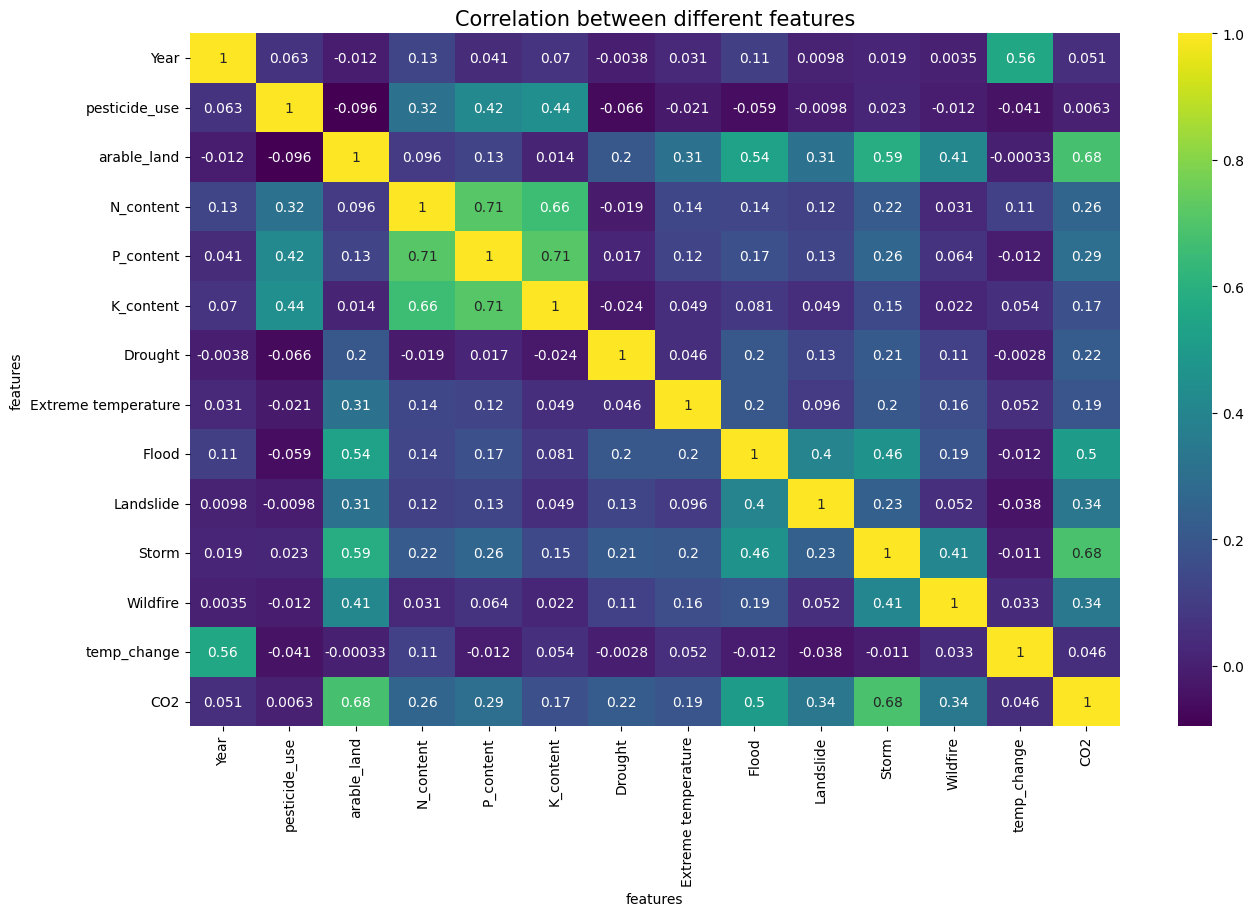

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(data.corr(), annot=True,cmap='viridis')
ax.set(xlabel='features')
ax.set(ylabel='features')

plt.title('Correlation between different features', fontsize = 15, c='black')
plt.show()

### From above heat map we don't see any significat correlation between parameters. Hence we will be retaining all the parameter for preparing the models.

Note: Threshold for considering any parmeters correlated is taken as 0.80.

In [ ]:
wheat= pd.merge(data_wheat_trim, data, on=['Year','Code'])
rice= pd.merge(data_rice_trim, data, on=['Year','Code'])
soybean= pd.merge(data_soybean_trim, data, on=['Year','Code'])
maize= pd.merge(data_maize_trim, data, on=['Year','Code'])

# Imputing missing values in temperature data from missing tempearture dataset.

In [ ]:

def replace_temp(df):
  ind=df.loc[pd.isnull(df).any(1), :].index.values
  for i in ind:
    year=(df.loc[i])["Year"]
    code=(df.loc[i])["Code"]
    t=missing_temp[(missing_temp["Code"]==code)]
    t=t[t["Year"]==year]

    df.loc[i, "temp_change"]=float(t["change_in_temp"])
  return df


In [ ]:
wheat.info()
wheat.isna().sum()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4062 entries, 0 to 4061
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 4062 non-null   object 
 1   Year                 4062 non-null   int64  
 2   wheat                4062 non-null   float64
 3   pesticide_use        4062 non-null   float64
 4   arable_land          4062 non-null   float64
 5   N_content            4062 non-null   float64
 6   P_content            4062 non-null   float64
 7   K_content            4062 non-null   float64
 8   Drought              4062 non-null   int64  
 9   Extreme temperature  4062 non-null   int64  
 10  Flood                4062 non-null   int64  
 11  Landslide            4062 non-null   int64  
 12  Storm                4062 non-null   int64  
 13  Wildfire             4062 non-null   int64  
 14  temp_change          3982 non-null   float64
 15  CO2                  4062 non-null   f

Code                    0
Year                    0
wheat                   0
pesticide_use           0
arable_land             0
N_content               0
P_content               0
K_content               0
Drought                 0
Extreme temperature     0
Flood                   0
Landslide               0
Storm                   0
Wildfire                0
temp_change            80
CO2                     0
dtype: int64

In [ ]:
wheat=replace_temp(wheat)
wheat.isna().sum()

Code                   0
Year                   0
wheat                  0
pesticide_use          0
arable_land            0
N_content              0
P_content              0
K_content              0
Drought                0
Extreme temperature    0
Flood                  0
Landslide              0
Storm                  0
Wildfire               0
temp_change            0
CO2                    0
dtype: int64

In [ ]:
rice.info()
rice.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4131 entries, 0 to 4130
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 4131 non-null   object 
 1   Year                 4131 non-null   int64  
 2   rice                 4131 non-null   float64
 3   pesticide_use        4131 non-null   float64
 4   arable_land          4131 non-null   float64
 5   N_content            4131 non-null   float64
 6   P_content            4131 non-null   float64
 7   K_content            4131 non-null   float64
 8   Drought              4131 non-null   int64  
 9   Extreme temperature  4131 non-null   int64  
 10  Flood                4131 non-null   int64  
 11  Landslide            4131 non-null   int64  
 12  Storm                4131 non-null   int64  
 13  Wildfire             4131 non-null   int64  
 14  temp_change          4059 non-null   float64
 15  CO2                  4131 non-null   f

Code                    0
Year                    0
rice                    0
pesticide_use           0
arable_land             0
N_content               0
P_content               0
K_content               0
Drought                 0
Extreme temperature     0
Flood                   0
Landslide               0
Storm                   0
Wildfire                0
temp_change            72
CO2                     0
dtype: int64

In [ ]:
rice=replace_temp(rice)
rice.isna().sum()

Code                   0
Year                   0
rice                   0
pesticide_use          0
arable_land            0
N_content              0
P_content              0
K_content              0
Drought                0
Extreme temperature    0
Flood                  0
Landslide              0
Storm                  0
Wildfire               0
temp_change            0
CO2                    0
dtype: int64

In [ ]:
soybean.info()
soybean.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3615 entries, 0 to 3614
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 3615 non-null   object 
 1   Year                 3615 non-null   int64  
 2   soybean              3615 non-null   float64
 3   pesticide_use        3615 non-null   float64
 4   arable_land          3615 non-null   float64
 5   N_content            3615 non-null   float64
 6   P_content            3615 non-null   float64
 7   K_content            3615 non-null   float64
 8   Drought              3615 non-null   int64  
 9   Extreme temperature  3615 non-null   int64  
 10  Flood                3615 non-null   int64  
 11  Landslide            3615 non-null   int64  
 12  Storm                3615 non-null   int64  
 13  Wildfire             3615 non-null   int64  
 14  temp_change          3553 non-null   float64
 15  CO2                  3615 non-null   f

Code                    0
Year                    0
soybean                 0
pesticide_use           0
arable_land             0
N_content               0
P_content               0
K_content               0
Drought                 0
Extreme temperature     0
Flood                   0
Landslide               0
Storm                   0
Wildfire                0
temp_change            62
CO2                     0
dtype: int64

In [ ]:
soybean=replace_temp(soybean)
soybean.isna().sum()

Code                   0
Year                   0
soybean                0
pesticide_use          0
arable_land            0
N_content              0
P_content              0
K_content              0
Drought                0
Extreme temperature    0
Flood                  0
Landslide              0
Storm                  0
Wildfire               0
temp_change            0
CO2                    0
dtype: int64

In [ ]:
maize.info()
maize.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5108 entries, 0 to 5107
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 5108 non-null   object 
 1   Year                 5108 non-null   int64  
 2   maize                5108 non-null   float64
 3   pesticide_use        5108 non-null   float64
 4   arable_land          5108 non-null   float64
 5   N_content            5108 non-null   float64
 6   P_content            5108 non-null   float64
 7   K_content            5108 non-null   float64
 8   Drought              5108 non-null   int64  
 9   Extreme temperature  5108 non-null   int64  
 10  Flood                5108 non-null   int64  
 11  Landslide            5108 non-null   int64  
 12  Storm                5108 non-null   int64  
 13  Wildfire             5108 non-null   int64  
 14  temp_change          5003 non-null   float64
 15  CO2                  5108 non-null   f

Code                     0
Year                     0
maize                    0
pesticide_use            0
arable_land              0
N_content                0
P_content                0
K_content                0
Drought                  0
Extreme temperature      0
Flood                    0
Landslide                0
Storm                    0
Wildfire                 0
temp_change            105
CO2                      0
dtype: int64

In [ ]:
maize=replace_temp(maize)
maize.isna().sum()

Code                   0
Year                   0
maize                  0
pesticide_use          0
arable_land            0
N_content              0
P_content              0
K_content              0
Drought                0
Extreme temperature    0
Flood                  0
Landslide              0
Storm                  0
Wildfire               0
temp_change            0
CO2                    0
dtype: int64

In [ ]:
#missing_temp["Code"].unique()

In [ ]:
#r=df_temp_country.loc[pd.isnull(df_temp_country).any(1), :].index.values
#r

In [ ]:
# s=df_temp_country.loc[r]
# s['Code'].unique()

# Muller Loop

#### **bold text** Running muller loop for regression for wheat, rice, soybean and maize. For this purpose we will remoce the country code and just take rest of the attribures just to find in the case of other attributes can we forecast the production of these 4 crops.

In [ ]:

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random


def muller_loop(df,value):
  lst=list(df.columns)
  lst.remove(value)
  lst.remove("Code")
  features = df[lst]
  label = df[[value]]
  X,y=(features,label)
  X = StandardScaler().fit_transform(X)
  random.seed(10)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


  names = ["Multiple Linear Regression", "Lasso Regression","Decision Tree Regressor", "Random Forest Regressor"]
# Train decision tree classifier
  regressors = [linear_model.LinearRegression(),linear_model.Lasso(alpha=0.1),DecisionTreeRegressor(random_state=2,max_depth=5),RandomForestRegressor(max_depth=5)]
  max_score = 0.0
  max_class = ''
  timetaken=[]
  score_all=[]
  # iterate over classifiers
  for name, clf in zip(names, regressors):
      start_time = time.time()
      clf.fit(X_train, y_train)

  #    accuracy =  np.mean(y_pred == y_test)100.0 *
  #print("Accuracy:", accuracy)
      score = 100.0 * clf.score(X_test, y_test)
      score_all.append(score)
      timetaken.append((time.time() - start_time))
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  return(names,score_all)



In [ ]:
# Comparision Plot
def plot_comparision(names, score_all):
  plt.figure(figsize=(20, 10))
  plt.bar(names, score_all)
  plt.show()


## Muller Loop for wheat production

In [ ]:
names,score_all=muller_loop(wheat,"wheat")

Classifier = Multiple Linear Regression, Score (test, accuracy) = 78.49, Training time = 0.03 seconds
Classifier = Lasso Regression, Score (test, accuracy) = 78.49, Training time = 0.03 seconds
Classifier = Decision Tree Regressor, Score (test, accuracy) = 91.40, Training time = 0.05 seconds
Classifier = Random Forest Regressor, Score (test, accuracy) = 92.05, Training time = 2.07 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest Regressor, Score (test, accuracy) = 92.05


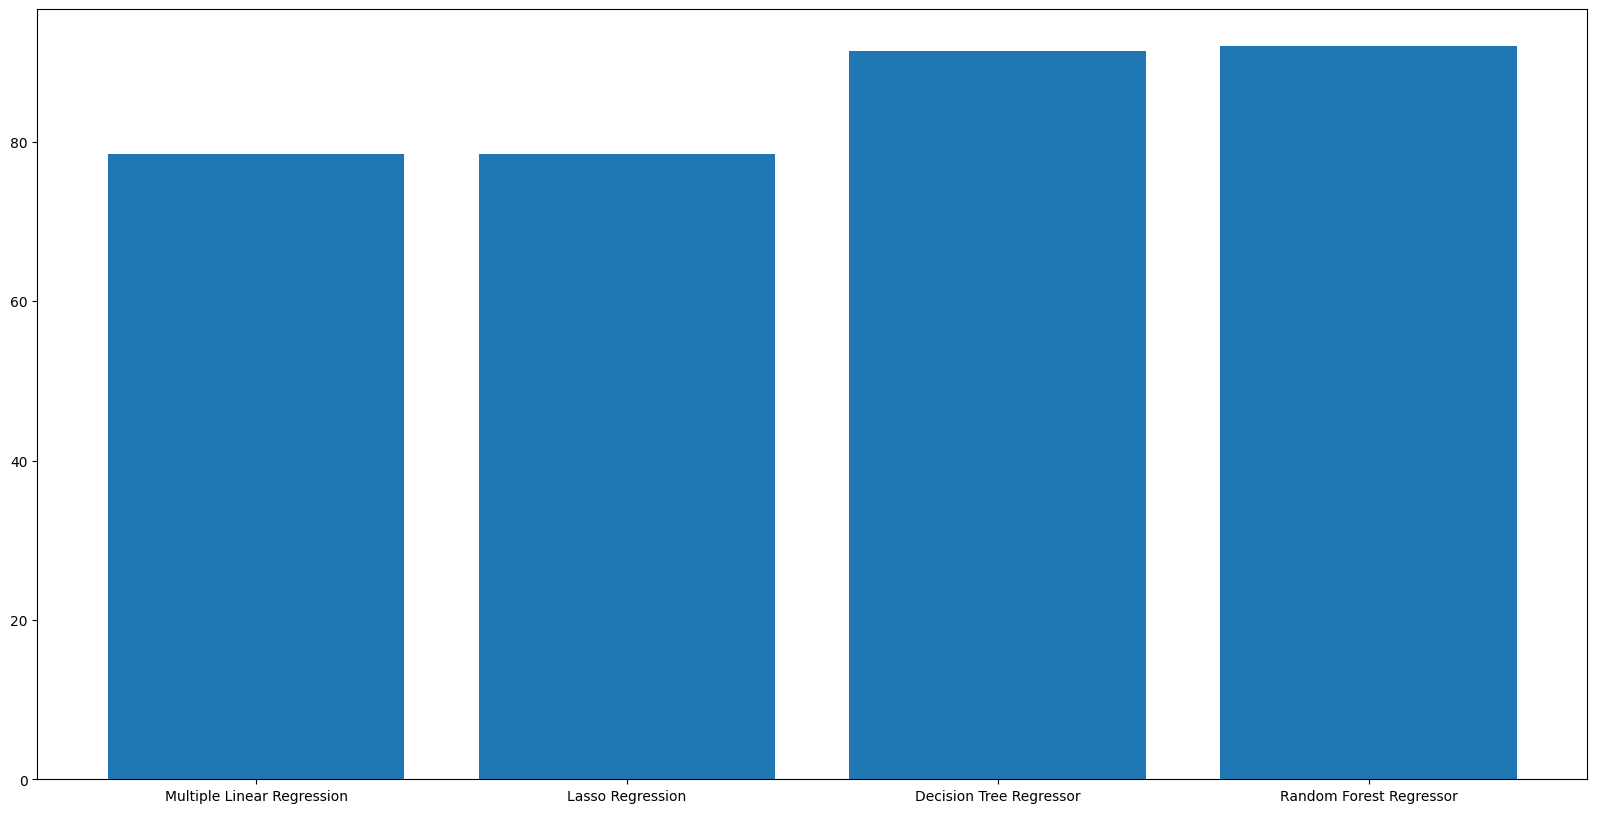

In [ ]:
plot_comparision(names,score_all)

## Muller Loop for rice production

In [ ]:
names,score_all=muller_loop(rice,"rice")

Classifier = Multiple Linear Regression, Score (test, accuracy) = 70.35, Training time = 0.04 seconds
Classifier = Lasso Regression, Score (test, accuracy) = 70.35, Training time = 0.07 seconds
Classifier = Decision Tree Regressor, Score (test, accuracy) = 93.79, Training time = 0.04 seconds
Classifier = Random Forest Regressor, Score (test, accuracy) = 94.53, Training time = 2.23 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest Regressor, Score (test, accuracy) = 94.53


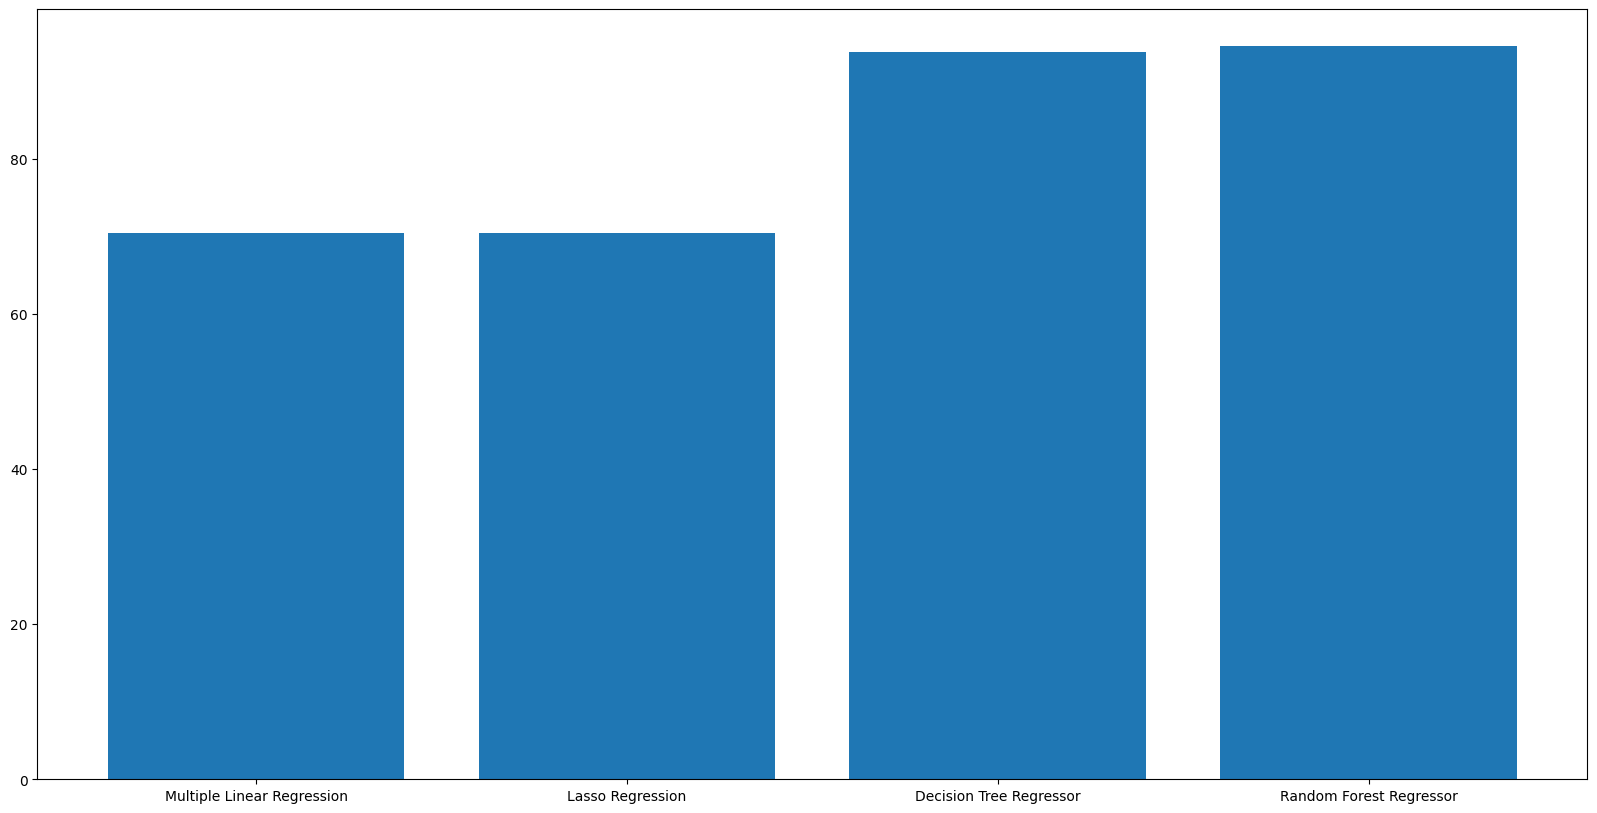

In [ ]:
plot_comparision(names,score_all)

## Muller Loop for soybean production

In [ ]:
names,score_all=muller_loop(soybean,"soybean")

Classifier = Multiple Linear Regression, Score (test, accuracy) = 29.32, Training time = 0.02 seconds
Classifier = Lasso Regression, Score (test, accuracy) = 29.32, Training time = 0.03 seconds
Classifier = Decision Tree Regressor, Score (test, accuracy) = 94.34, Training time = 0.06 seconds
Classifier = Random Forest Regressor, Score (test, accuracy) = 96.92, Training time = 2.10 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest Regressor, Score (test, accuracy) = 96.92


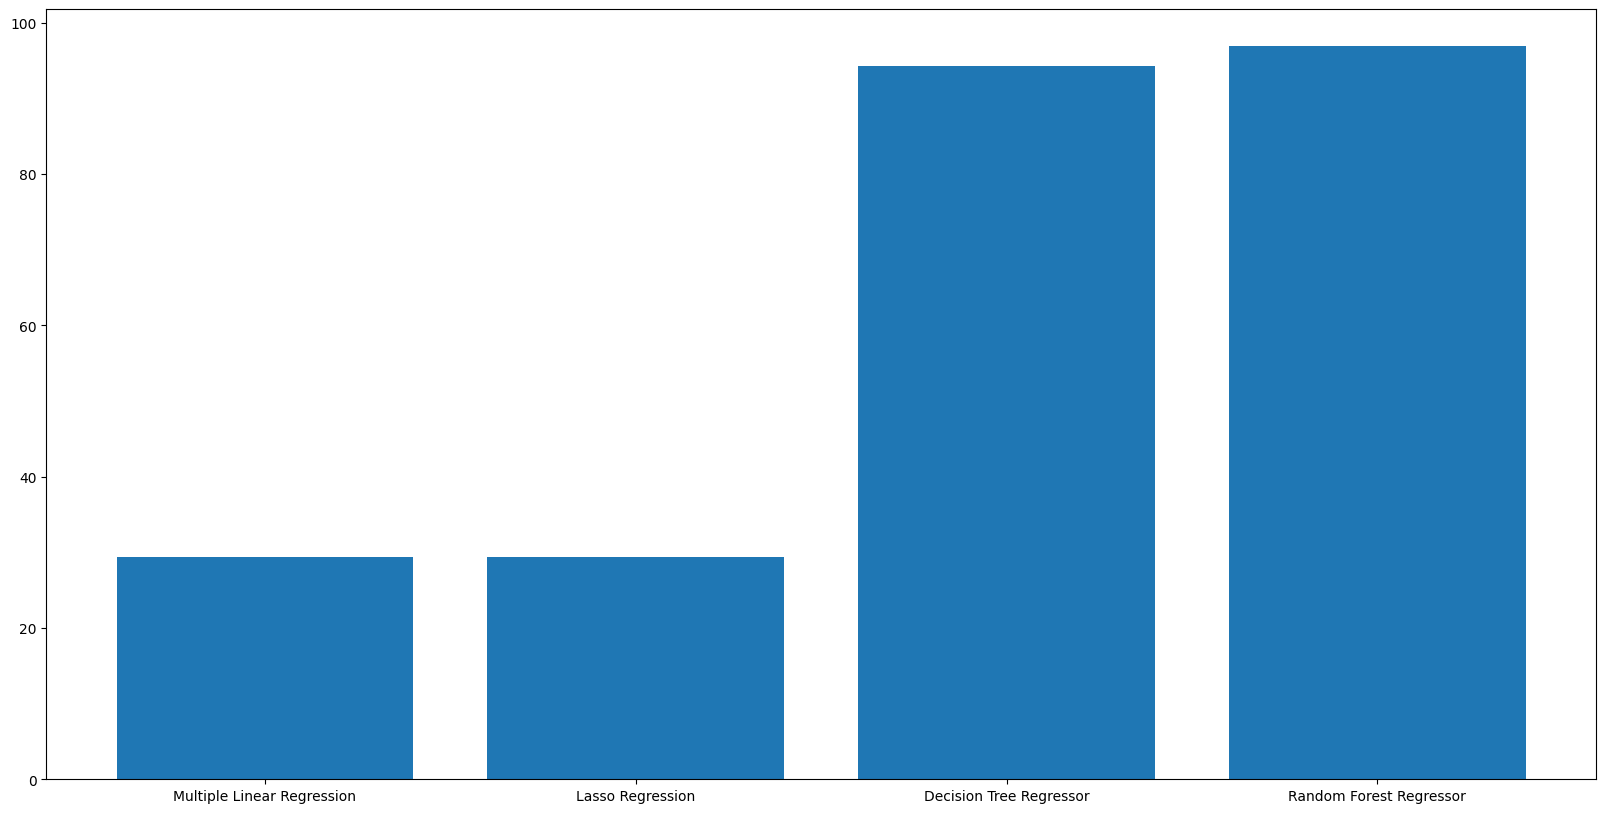

In [ ]:
plot_comparision(names,score_all)

## Muller Loop for maize production

In [ ]:
names,score_all=muller_loop(maize,"maize")

Classifier = Multiple Linear Regression, Score (test, accuracy) = 81.86, Training time = 0.04 seconds
Classifier = Lasso Regression, Score (test, accuracy) = 81.86, Training time = 0.08 seconds
Classifier = Decision Tree Regressor, Score (test, accuracy) = 85.19, Training time = 0.14 seconds
Classifier = Random Forest Regressor, Score (test, accuracy) = 90.57, Training time = 4.88 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest Regressor, Score (test, accuracy) = 90.57


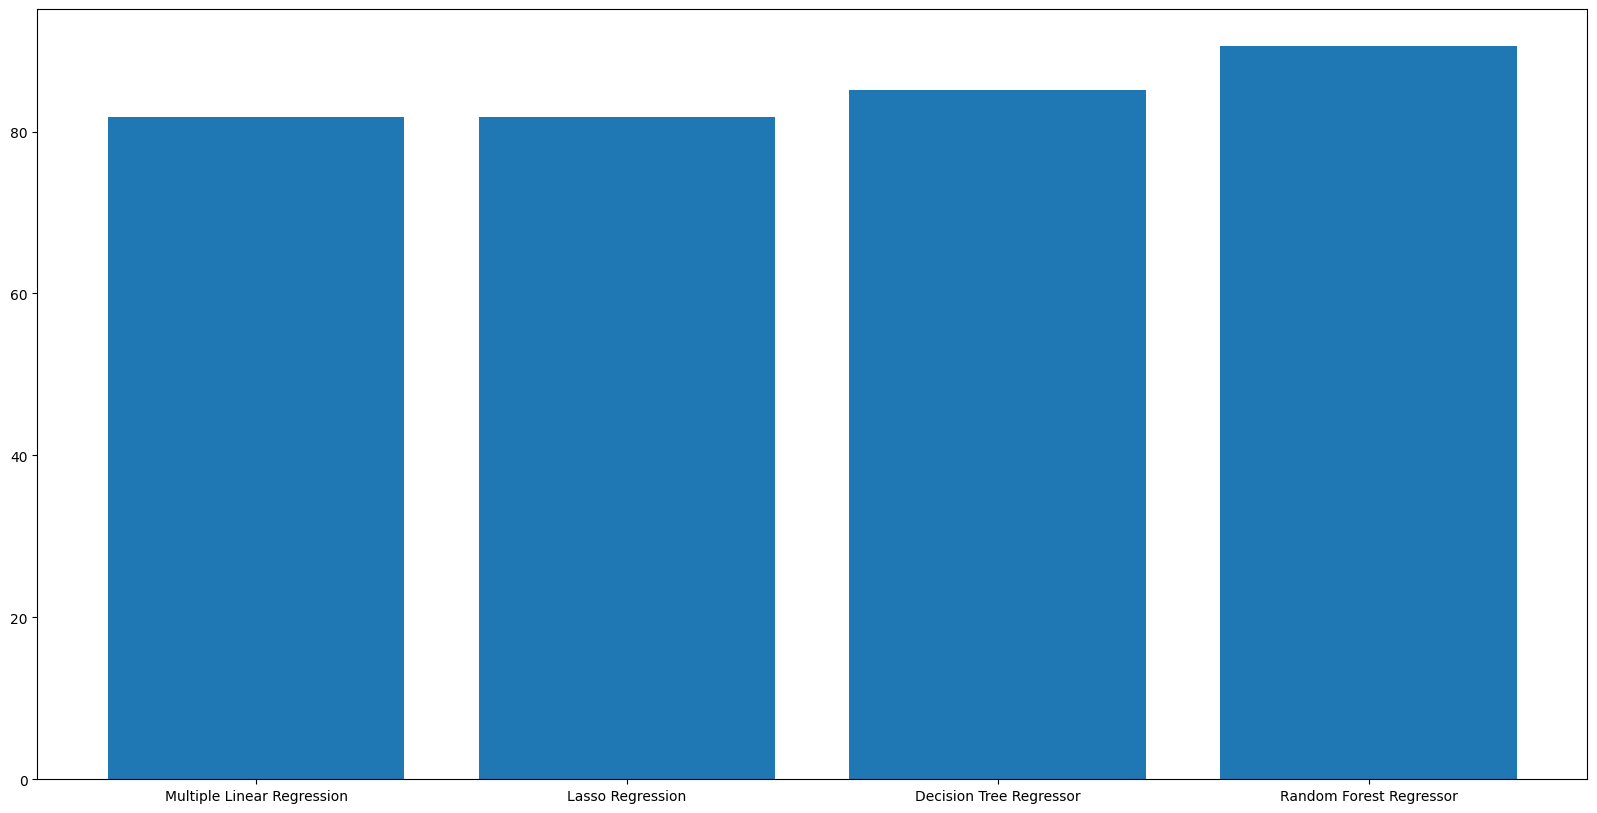

In [ ]:
plot_comparision(names,score_all)

# Conclusion

Random Forest is providing the best results with around 95% for the crop production taken under consideration.